# Fusion-in-Decoder (FiD)

In this tutorial, we will utilize the FiD model to read multiple documents in parallel, to generate an answer for any question.

We will use a pipeline that will:

- Fetch relevant documents for our question.
- Rerank the documents for better performance.
- Read the documents in parallel and generate using FiD.

For more information about FiD, we encourage reading the original paper: [Leveraging Passage Retrieval with Generative Models
for Open Domain Question Answering](https://arxiv.org/pdf/2007.01282.pdf). 


In [ ]:
from haystack import Document, Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.rankers import TransformersSimilarityRanker

We start from a collection of paragraphs from Wikipedia, for the retrieval phase:

In [2]:
document_collection = [{'id': '11457596',
  'text': 'Quest", the "Ultima" series, "EverQuest", the "Warcraft" series, and the "Elder Scrolls" series of games as well as video games set in Middle-earth itself. Research also suggests that some consumers of fantasy games derive their motivation from trying to create an epic fantasy narrative which is influenced by "The Lord of the Rings". In 1965, songwriter Donald Swann, who was best known for his collaboration with Michael Flanders as Flanders & Swann, set six poems from "The Lord of the Rings" and one from "The Adventures of Tom Bombadil" ("Errantry") to music. When Swann met with Tolkien to play the',
  'title': 'The Lord of the Rings'},
 {'id': '11457582',
  'text': 'helped "The Lord of the Rings" become immensely popular in the United States in the 1960s. The book has remained so ever since, ranking as one of the most popular works of fiction of the twentieth century, judged by both sales and reader surveys. In the 2003 "Big Read" survey conducted in Britain by the BBC, "The Lord of the Rings" was found to be the "Nation\'s best-loved book". In similar 2004 polls both Germany and Australia also found "The Lord of the Rings" to be their favourite book. In a 1999 poll of Amazon.com customers, "The Lord of the',
  'title': 'The Lord of the Rings'},
 {'id': '11457540',
  'text': 'of Tolkien\'s works is such that the use of the words "Tolkienian" and "Tolkienesque" has been recorded in the "Oxford English Dictionary". The enduring popularity of "The Lord of the Rings" has led to numerous references in popular culture, the founding of many societies by fans of Tolkien\'s works, and the publication of many books about Tolkien and his works. "The Lord of the Rings" has inspired, and continues to inspire, artwork, music, films and television, video games, board games, and subsequent literature. Award-winning adaptations of "The Lord of the Rings" have been made for radio, theatre, and film. In',
  'title': 'The Lord of the Rings'},
 {'id': '11457587',
  'text': 'has been read as fitting the model of Joseph Campbell\'s "monomyth". "The Lord of the Rings" has been adapted for film, radio and stage. The book has been adapted for radio four times. In 1955 and 1956, the BBC broadcast "The Lord of the Rings", a 13-part radio adaptation of the story. In the 1960s radio station WBAI produced a short radio adaptation. A 1979 dramatization of "The Lord of the Rings" was broadcast in the United States and subsequently issued on tape and CD. In 1981, the BBC broadcast "The Lord of the Rings", a new dramatization in 26',
  'title': 'The Lord of the Rings'},
 {'id': '11457592',
  'text': '"The Lord of the Rings", was released on the internet in May 2009 and has been covered in major media. "Born of Hope", written by Paula DiSante, directed by Kate Madison, and released in December 2009, is a fan film based upon the appendices of "The Lord of the Rings". In November 2017, Amazon acquired the global television rights to "The Lord of the Rings", committing to a multi-season television series. The series will not be a direct adaptation of the books, but will instead introduce new stories that are set before "The Fellowship of the Ring". Amazon said the',
  'title': 'The Lord of the Rings'},
 {'id': '7733817',
  'text': 'The Lord of the Rings Online The Lord of the Rings Online: Shadows of Angmar is a massive multiplayer online role-playing game (MMORPG) for Microsoft Windows and OS X set in a fantasy universe based upon J. R. R. Tolkien\'s Middle-earth writings, taking place during the time period of "The Lord of the Rings". It launched in North America, Australia, Japan, and Europe in 2007. Originally subscription-based, it is free-to-play, with a paid VIP subscription available that provides players various perks.  The game\'s environment is based on "The Lord of the Rings" and "The Hobbit". However, Turbine does not',
  'title': 'The Lord of the Rings Online'},
 {'id': '22198847',
  'text': 'of "The Lord of the Rings", including Ian McKellen, Andy Serkis, Hugo Weaving, Elijah Wood, Ian Holm, Christopher Lee, Cate Blanchett and Orlando Bloom who reprised their roles. Although the "Hobbit" films were even more commercially successful than "The Lord of the Rings", they received mixed reviews from critics. Numerous video games were released to supplement the film series. They include: "," Pinball, "", "", , "", "", "", "", "The Lord of the Rings Online", "", "", "", "Lego The Lord of the Rings", "Guardians of Middle-earth", "", and "".',
  'title': 'The Lord of the Rings (film series)'},
 {'id': '24071573',
  'text': 'Lord of the Rings (musical) The Lord of the Rings is the most prominent of several theatre adaptations of J. R. R. Tolkien\'s epic high fantasy novel of the same name, with music by A. R. Rahman, Christopher Nightingale and the band Värttinä, and book and lyrics by Matthew Warchus and Shaun McKenna. Set in the world of Middle-earth, "The Lord of the Rings" tells the tale of a humble hobbit who is asked to play the hero and undertake a treacherous mission to destroy an evil, magic ring without being seduced by its power. The show was first performed',
  'title': 'Lord of the Rings (musical)'},
 {'id': '11457536',
  'text': 'The Lord of the Rings The Lord of the Rings is an epic high fantasy novel written by English author and scholar J. R. R. Tolkien. The story began as a sequel to Tolkien\'s 1937 fantasy novel "The Hobbit", but eventually developed into a much larger work. Written in stages between 1937 and 1949, "The Lord of the Rings" is one of the best-selling novels ever written, with over 150 million copies sold. The title of the novel refers to the story\'s main antagonist, the Dark Lord Sauron, who had in an earlier age created the One Ring to rule',
  'title': 'The Lord of the Rings'},
 {'id': '13304003',
  'text': "The Lord of the Rings (disambiguation) The Lord of the Rings is a fantasy novel by J. R. R. Tolkien. The title refers to Sauron, the story's main antagonist. The Lord of the Rings may also refer to:",
  'title': 'The Lord of the Rings (disambiguation)'}]

We then create an InMemoryDocumentStore document store, to store all the documents:

In [3]:
store = InMemoryDocumentStore()

In [4]:
documents = [Document(id=item["id"], content=item["text"], meta={"title": item["title"]}) for item in document_collection]

In [5]:
store.write_documents(documents)

10

Next, we create a simple BM25 retriever on top of our store, and an additional reranker component to improve the ranking of the documents used for answering the question:

In [6]:
retriever = InMemoryBM25Retriever(
    document_store= store,
    top_k= 10
)    

In [7]:
reranker = TransformersSimilarityRanker(
    model="cross-encoder/ms-marco-MiniLM-L-6-v2",
    top_k=1,
)

Now that we have created the retrieval components, we move to the LLM usage.
We create an FiD generator.

In [8]:
from fastrag.generators import FiDGenerator

In [9]:
FID = FiDGenerator(
    model="Intel/fid_flan_t5_base_nq",
    generation_kwargs={"max_length": 10, "do_sample": False},
    huggingface_pipeline_kwargs = {"device_map": "auto"}
)

Our components are now ready. We can now create a pipeline, to connect all of them together:

In [10]:
pipe = Pipeline()

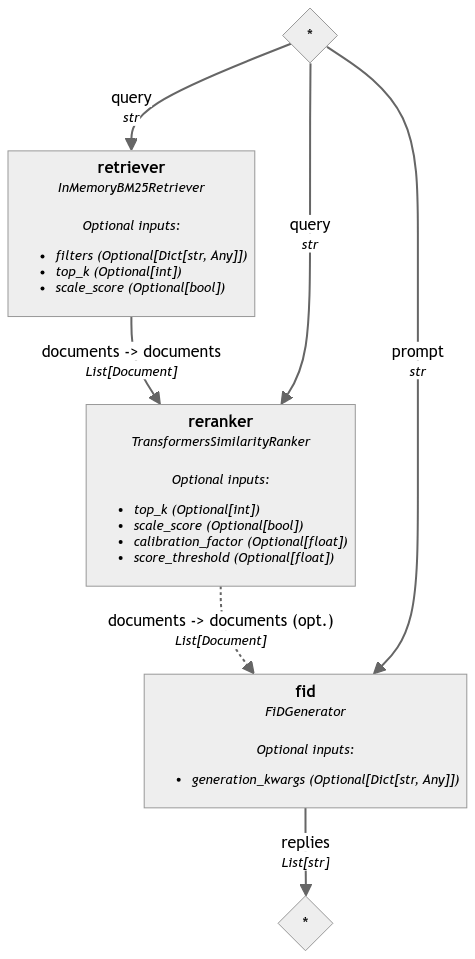

In [11]:
pipe.add_component("retriever", retriever)
pipe.add_component("reranker", reranker)
pipe.add_component("fid", FID)
pipe.connect("retriever", "reranker.documents")
pipe.connect("reranker", "fid.documents")

Finally, lets ask it a question:

In [35]:
question = "Who is the main villain in Lord of the Rings?"

In [36]:
answer_result = pipe.run({
    "retriever": {"query": question, "top_k": 8},
    "reranker": {"query": question, "top_k": 4},
    "fid": {"prompt": question},
})

Ranking by BM25...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 20281.93 docs/s]


In [37]:
answer_result["fid"]["replies"]

'Sauron'